## Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=250)

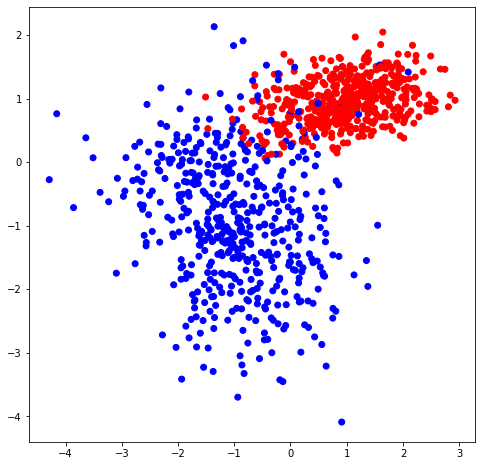

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

### Задание1
Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).


In [4]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

        
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))


    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
  
    return voted_predictions

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Создадим массив случайных лесов по 1, 3, 10, 50 деревьев в 3 вариантах.  

In [19]:
%%time
n_iteretion = 3
n_trees = [1,3, 10, 50]
my_forest = []
for it in range(n_iteretion):
    my_forest.append([random_forest(train_data, train_labels, el) for el in n_trees])

Wall time: 55.5 s


In [20]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(my_forest, train_data, test_data):
    plt.figure(figsize = (16, 7))
    plt.suptitle(f"случайный лес из {len(my_forest)} деревьев")
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [21]:
 %matplotlib inline

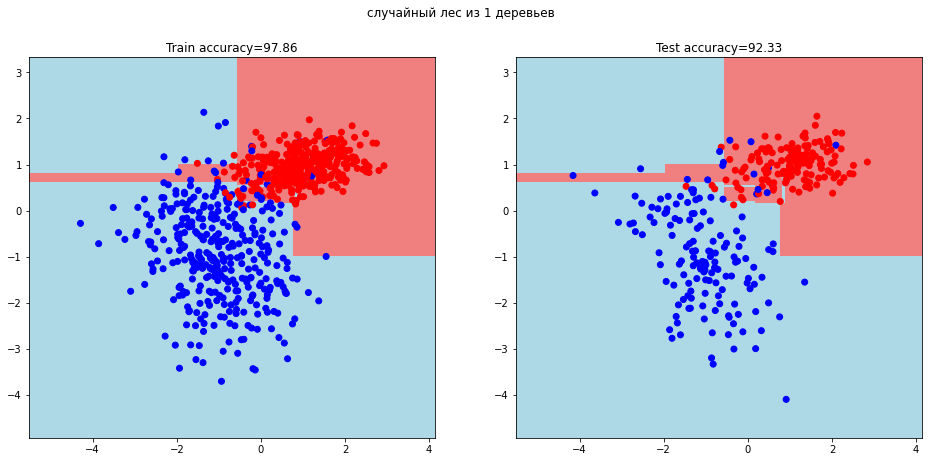

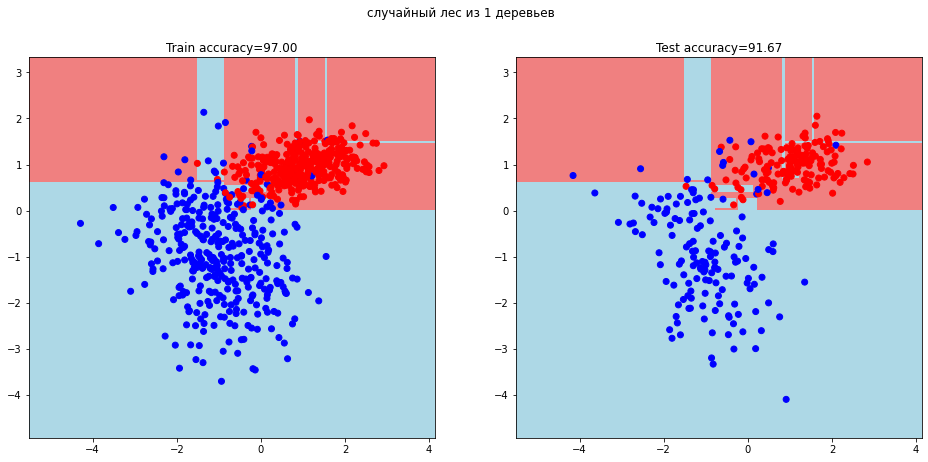

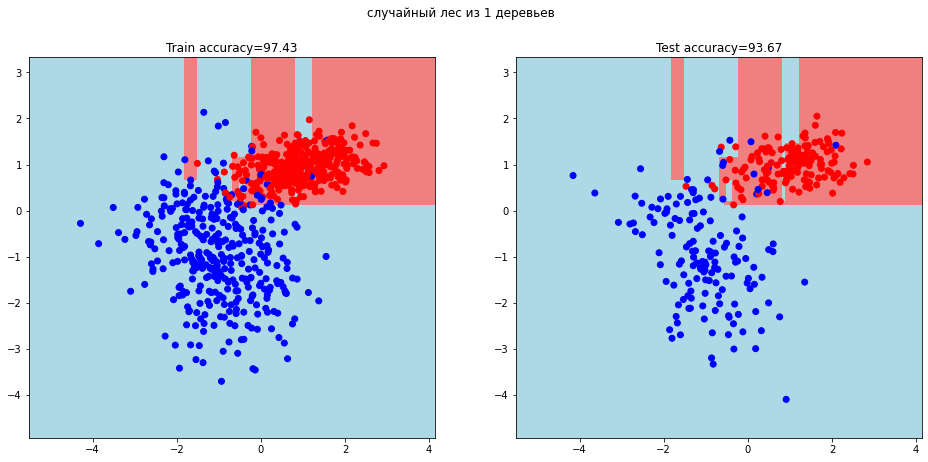

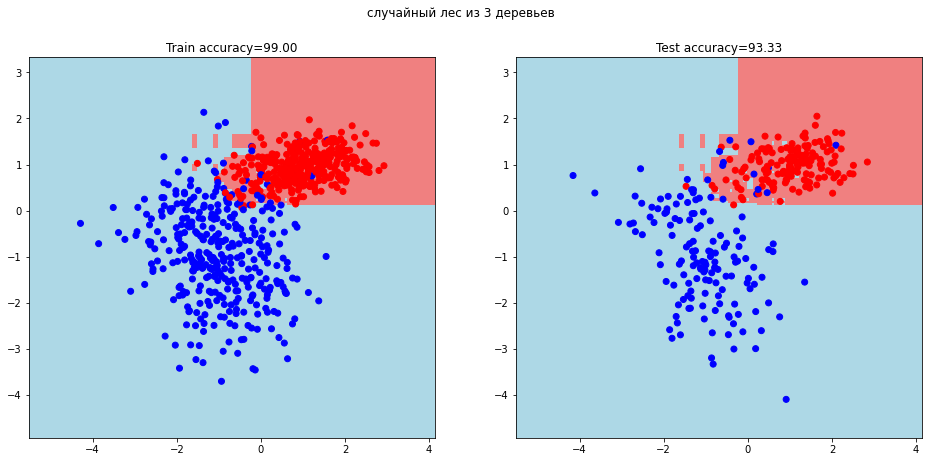

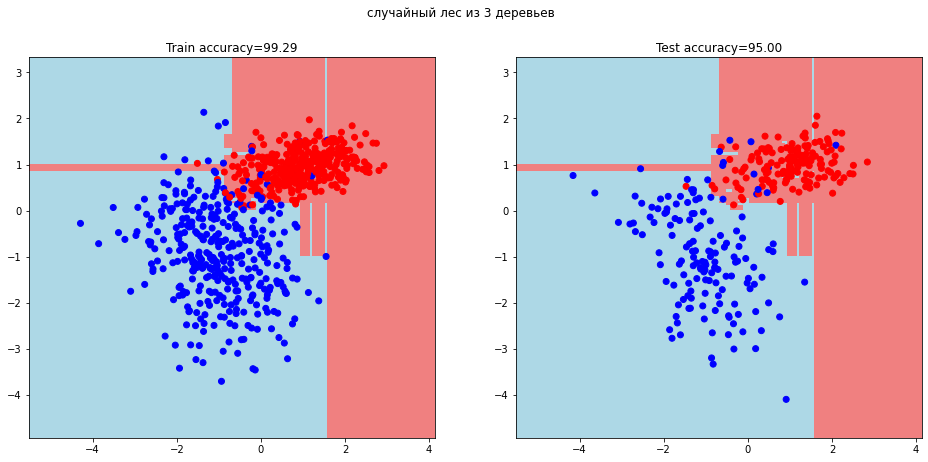

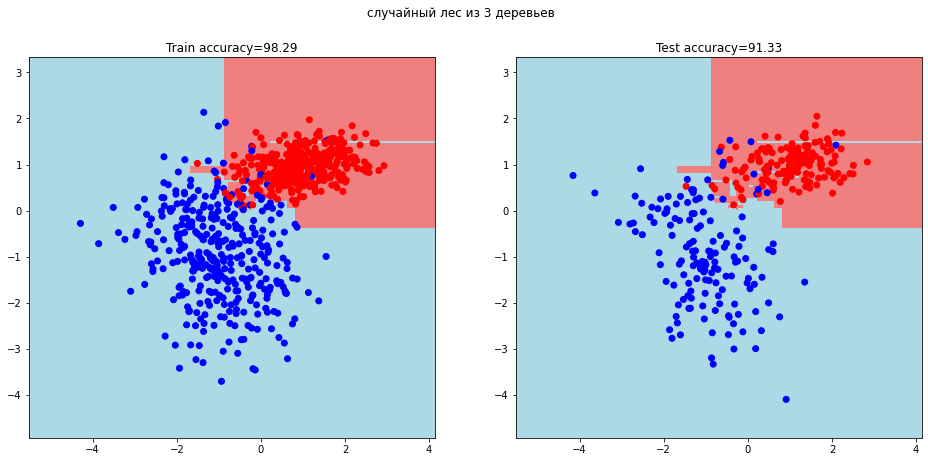

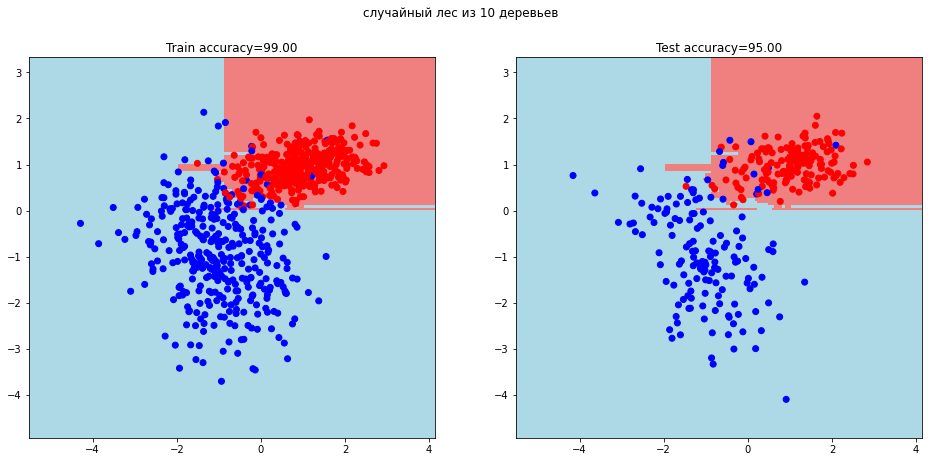

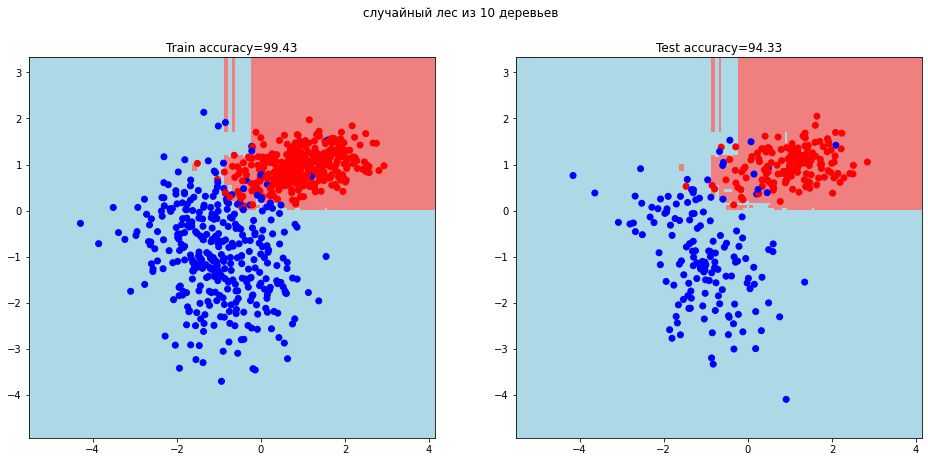

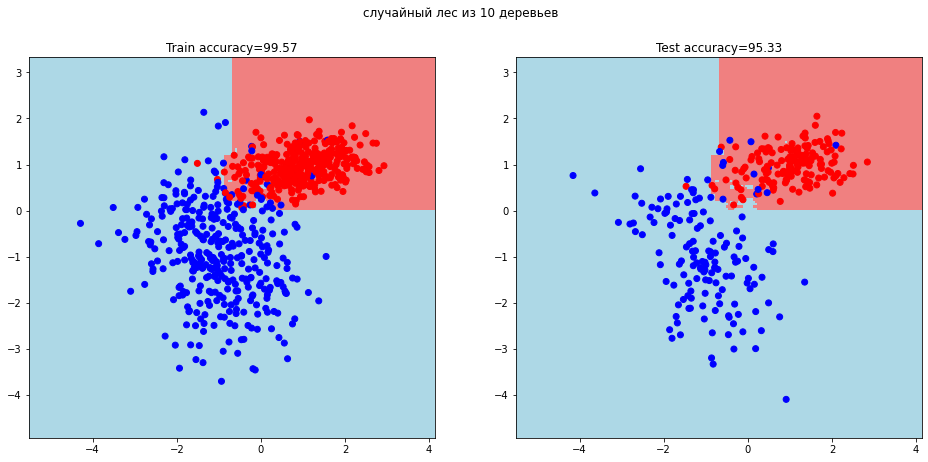

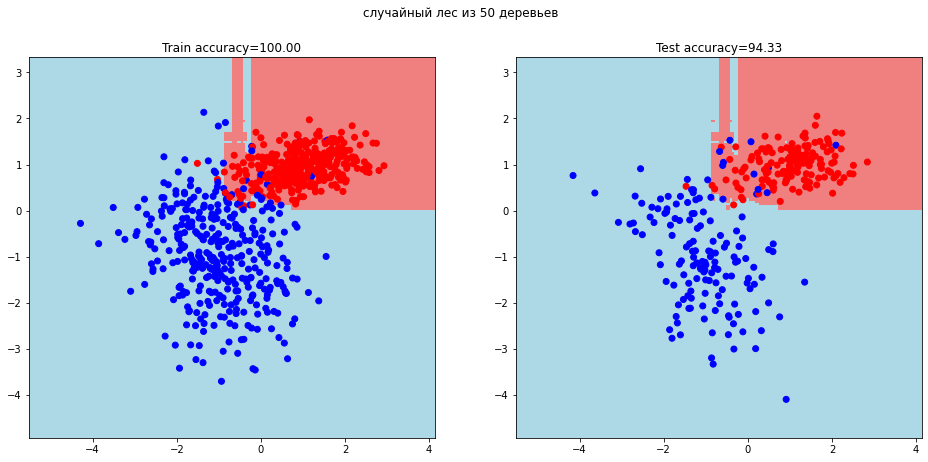

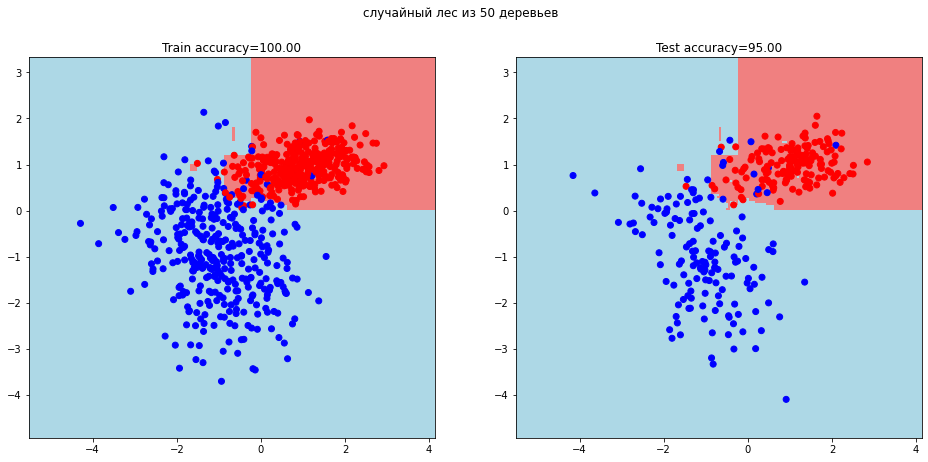

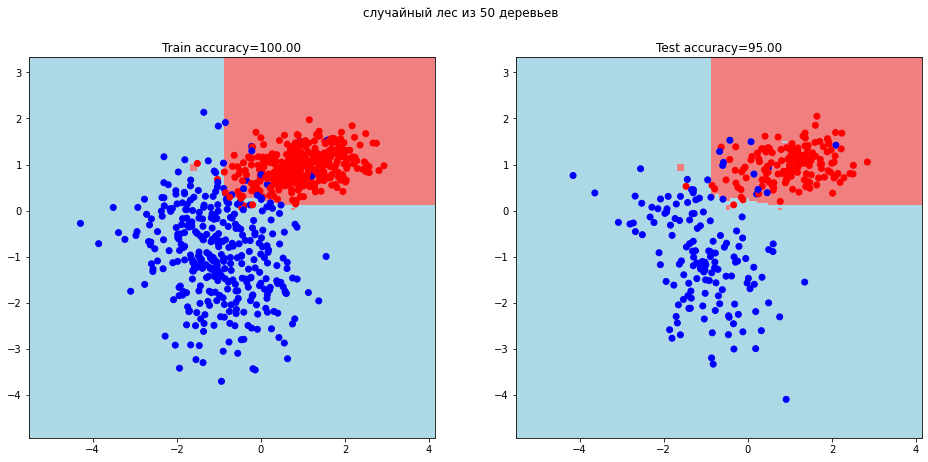

In [22]:
for index in range(len(n_trees)):
    for it in range(3):
        visualize(my_forest[it][index], train_data, test_data)

### Задание2
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Выводы по заданию 1: <br>
1. При росте количества деревьев в лесу также растёт сложность гиперплоскости. Плоскость начинает более точно описывать области классов. Когда число деревьев в лесу становится слишком велико, гиперплоскость начинает описывать область учебной выборки настолько подробно что возникает эффект переобучения. В приведённых выше графиках можно видеть, как модель подстраивала свою гиперплоскость под выборки.  

2. В варианте с 50 деревьями началось переобучение. При увеличении числа деревьев с 10 до 50 метрика на обучающей выборке увеличилась до 100%, а на тестовой выборке осталась без изменения. Поэтому можно сделать вывод, что при заданной выборке не имеет смысла строить лес из 50 деревьев.  

3. В случае с 1 или 3 деревьями мы видим недообучение. И при увеличении количества деревьев в лесу, полученные метрики увеличиваются как на обучающей, так и на тестовой выборках. А гиперплоскости разделяют выборки недостаточно точно. 

4. Делая по 3 итерации, я хотел посмотреть на сколько будут отличаться гиперплоскости и метрики от итерации к итерации. В результате я увидел, что если строить случайный лес при одних и тех же гиперпараметрах, то получаются разные модели, и изменение метрики +/- 1% может быть вызвано случайными процессами алгоритма построения леса.  

### Задание3

*Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [23]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]

# -----------------------------------------------------------------
        # выдали не только выборку но и индексы выборки
        bootstrap.append((b_data, b_labels, sample_index))
# -----------------------------------------------------------------

    return bootstrap

In [24]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
# ---------------------------------------------------------
    # создаём массив индексов на основе которых строилось дерево
    indexes = []
    
    for b_data, b_labels, simpl_index in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        indexes.append(simpl_index)
# ------------------------------------------------------------        
    return forest, indexes

Для обучения можно использовать всю сгенерированную выборку, не разделяя её на обучающую и тестовую.

In [25]:
%%time
n_trees = 50
my_forest, indexes = random_forest(classification_data, classification_labels, n_trees)

Wall time: 30 s


In [26]:
# предсказание голосованием деревьев

def Out_of_bag(forest, indexes, data):

   
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

        
    # сформируем список с предсказаниями для каждого объекта
    
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)


# ----------------------------------------------------------------------------------------
    # в качестве данных для предсказания объекта будут отбираться предсказания деревьев в индексах выборки которых нет 
    # номера данного объекта 
    result = [] 
    for obj in range(len(predictions_per_object)):
        ob = []
        for tree in range(len(forest)):
            if obj not in indexes[tree]:
                ob.append(predictions_per_object[obj][tree])
        if len(ob)==0:        # в случае если в объект попал во все деревья и по нему нет 
    # нет возможност исформировать "выборку для теста" будем использовать предсказания всех деревьев. 
    # Такая ситуация свойственна при малом количестве деревьев. 
            result.append(predictions_per_object[obj])
            print('Нет тестовых данных')            
        else:
            result.append(ob)
#     print(resul)
# ---------------------------------------------------------------------------------------
   
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in result:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

предсказание модели по алгоритму Out-of-Bag

In [27]:
oob = Out_of_bag(my_forest, indexes, classification_data)

In [28]:
accuracy = accuracy_metric(classification_labels, oob)
print('Метрика accuracy для Out-of-Bag: ',round(accuracy, 3))

Метрика accuracy для Out-of-Bag:  95.2


### Задание4
*(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [29]:
# Расчет энтропии Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    h = 0
    for label in classes:
        p = classes[label] / len(labels)
        h +=p*np.log2(p)
        
    return h